<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "AI"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/AI/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


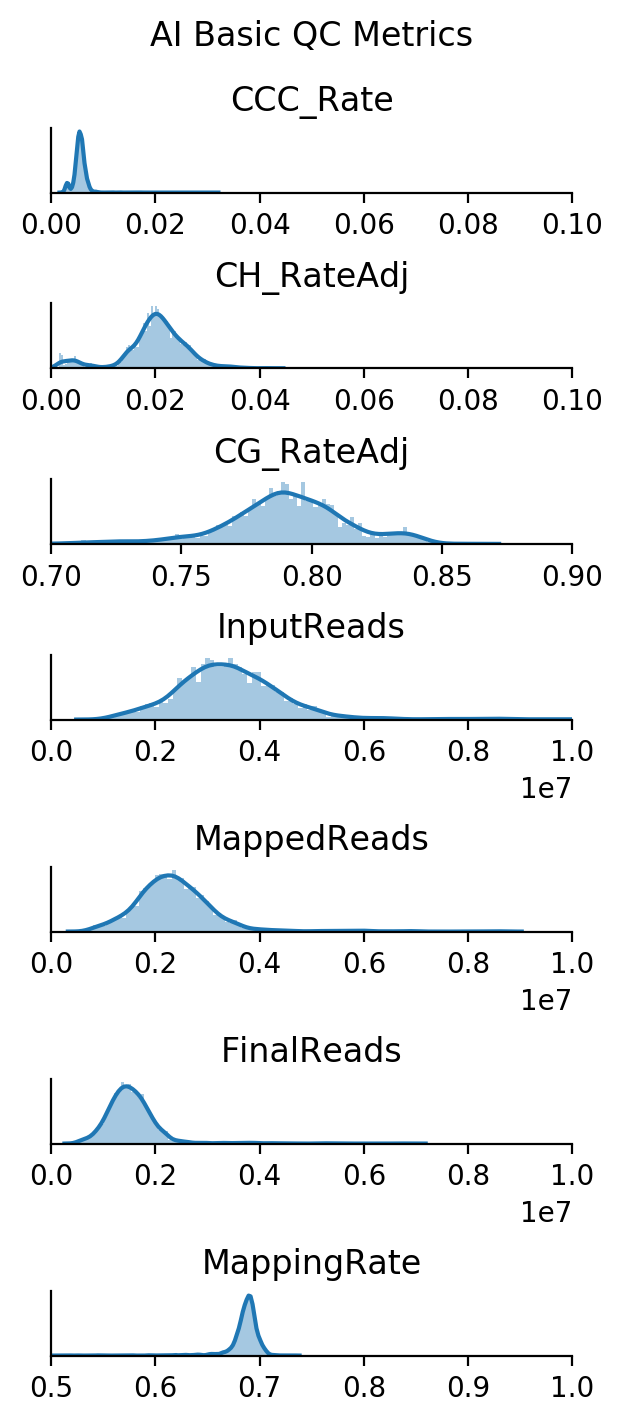

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

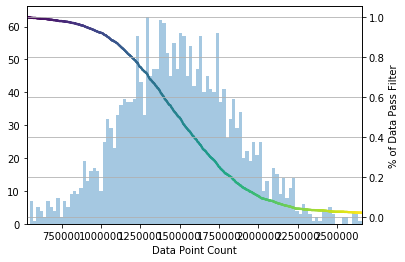

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2345/2345 (100.0%)
CG_RateAdj passed 2345/2345 (100.0%)
CH_RateAdj passed 2345/2345 (100.0%)
FinalReads passed 2345/2345 (100.0%)
MappingRate passed 2345/2345 (100.0%)
Overall passed 2345/2345 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180412 1086
180416 1259


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 303 78.9%
ad002 290 75.5%
ad004 294 76.6%
ad006 296 77.1%
ad007 297 77.3%
ad008 297 77.3%
ad010 287 74.7%
ad012 281 73.2%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
3D_M_0,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00531,0.80417,0.80312,0.02411,0.01890,981644.0,1912368,1318653.0,3D,...,23.475544,8.370895,-24.706684,-24.878013,CT-L6 Megf9,-1.792766,-14.683293,-11.319322,-3.323591,True
3D_M_1,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00602,0.79285,0.79160,0.02653,0.02063,1120147.0,2192090,1522959.0,3D,...,12.814552,-3.890029,4.760095,-18.645373,IT-L6 Man1c1,-11.340764,-6.354976,15.134937,-10.862592,True
3D_M_10,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00378,0.71431,0.71323,0.00762,0.00385,1632031.0,3779188,2549148.0,3D,...,6.769331,11.524736,-67.648469,-9.555586,PC pc-all,-0.756455,9.718030,4.552105,-0.403926,True
3D_M_100,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00721,0.80201,0.80057,0.03389,0.02687,1630762.0,3743826,2525240.0,3D,...,11.074458,-11.335084,20.103199,12.032352,IT-L5 Grik3,3.679873,2.244427,11.225952,22.378069,True
3D_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00481,0.78350,0.78245,0.02106,0.01633,2160311.0,5050282,3326082.0,3D,...,1.713344,-10.439082,-11.474313,33.367613,IT-L23 Cux1,-0.648953,3.228657,1.627271,3.907558,True
3D_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00610,0.82263,0.82154,0.03087,0.02492,2136659.0,5617298,3333191.0,3D,...,-27.002737,4.695364,-0.593209,-31.922242,MGE-Pvalb Sema5a,-1.982599,-11.411197,0.198757,13.573536,True
3D_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00590,0.81467,0.81357,0.02892,0.02316,1699524.0,3889576,2667421.0,3D,...,-27.864365,5.615932,3.338187,-24.465031,MGE-Pvalb Entpd3,-0.718457,-3.956924,8.168642,-20.913177,True
3D_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00597,0.80863,0.80748,0.02813,0.02229,1411100.0,3251714,2232270.0,3D,...,23.573570,8.461221,-24.326410,-25.834231,CT-L6 Tnr,-4.189355,-20.576288,-18.169854,-5.132308,True
3D_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00542,0.78989,0.78874,0.02367,0.01835,1342807.0,3022782,2100809.0,3D,...,14.937567,-8.731791,4.070319,2.957949,IT-L6 Man1c1,-0.584830,-7.133377,-28.016373,-13.781045,True
3D_M_1006,/gale/raidix/rdx-4/CEMBA_RS1/3D/CEMBA180412_3D...,0.00619,0.78131,0.77995,0.03253,0.02650,1577907.0,3403930,2361000.0,3D,...,13.034943,-9.904487,27.338052,8.128850,IT-L5 Grik3,5.132126,-3.069310,-1.120300,39.617225,True
